<a href="https://colab.research.google.com/github/ryeorin/Colab/blob/main/LSTM_practice_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM 실습 1 :  삼성전자 주가 데이터 예측하기

## 삼성전자 주가 데이터 불러오기
1. 구글 드라이브 마운트하기
2. 아래 [folder_name] 변수를 프로젝트 루트 디렉토리 이름으로 수정하기

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_name = 'lec'
root_dir = os.path.join('/content/drive/MyDrive', folder_name)

In [ ]:
import pandas as pd

df = pd.read_csv(os.path.join(root_dir, 'samsung_cospi.csv'), index_col='Date')

df.head(5)

# Date :  날짜
# High :  고가
# Low :  저가
# Open :  시가
# Adj Close : 조정 종가 -> target
# Close :  종가

,High,Low,Open,Volume,Adj Close,Close
Date,,,,,,
2000-01-04,6110,5660,6000,74195000,4719.226074,6110
2000-01-05,6060,5520,5800,74680000,4309.866211,5580
2000-01-06,5780,5580,5750,54390000,4340.761230,5620
2000-01-07,5670,5360,5560,40305000,4278.971680,5540
2000-01-10,5770,5580,5600,46880000,4456.618652,5770


## 학습 준비
1. 입력 데이터 준비
2. 하이퍼파라미터 정의
3. 모델 정의

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [ ]:
X = df.drop(columns='Adj Close')
y = df.iloc[:, 4:5]

In [ ]:
print(X, y, sep='\n\n')

             High    Low   Open    Volume  Close
Date                                            
2000-01-04   6110   5660   6000  74195000   6110
2000-01-05   6060   5520   5800  74680000   5580
2000-01-06   5780   5580   5750  54390000   5620
2000-01-07   5670   5360   5560  40305000   5540
2000-01-10   5770   5580   5600  46880000   5770
...           ...    ...    ...       ...    ...
2021-07-26  79500  78800  79400  10040975  78800
2021-07-27  79400  78500  79200  11427693  78500
2021-07-28  79200  78100  78300  12743417  79200
2021-07-29  79400  78800  78800  14360453  79000
2021-07-30  78900  78500  78900  13823411  78500

[5419 rows x 5 columns]

               Adj Close
Date                    
2000-01-04   4719.226074
2000-01-05   4309.866211
2000-01-06   4340.761230
2000-01-07   4278.971680
2000-01-10   4456.618652
...                  ...
2021-07-26  78800.000000
2021-07-27  78500.000000
2021-07-28  79200.000000
2021-07-29  79000.000000
2021-07-30  78500.000000

[5419 rows 

In [ ]:
!pip install scikit-learn==1.2.2

from sklearn.preprocessing import MinMaxScaler

In [ ]:
mm = MinMaxScaler()
ss = MinMaxScaler()

In [ ]:
y_mm = mm.fit_transform(y)
y_mm

array([[0.02963617],
       [0.02498908],
       [0.0253398 ],
       ...,
       [0.8751488 ],
       [0.87287838],
       [0.86720234]])

In [ ]:
X_ss = ss.fit_transform(X)
X_ss

array([[0.03562314, 0.03720717, 0.03942571, 0.45181622, 0.03829161],
       [0.03509145, 0.03559945, 0.03714676, 0.45476966, 0.0322873 ],
       [0.03211399, 0.03628847, 0.03657703, 0.33121213, 0.03274046],
       ...,
       [0.8128456 , 0.8690859 , 0.86326345, 0.07760203, 0.86631925],
       [0.81497235, 0.87712448, 0.8689608 , 0.08744909, 0.86405347],
       [0.80965547, 0.87367938, 0.87010027, 0.08417874, 0.85838903]])

In [ ]:
X_train = X_ss[:4800, :]
X_test = X_ss[4800:, :]

y_train = y_mm[:4800, :]
y_test = y_mm[4800:, :]


print("X_train: {}, y_train: {}".format(X_train.shape, y_train.shape))
print("X_test: {}, y_test: {}".format(X_test.shape, y_test.shape))

X_train: (4800, 5), y_train: (4800, 1)
X_test: (619, 5), y_test: (619, 1)


In [ ]:
X_train = torch.FloatTensor(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = torch.FloatTensor(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)


print("Training set: ", X_train.shape, y_train.shape)
print("Testing set: ", X_test.shape, y_test.shape)

Training set:  torch.Size([4800, 1, 5]) torch.Size([4800, 1])
Testing set:  torch.Size([619, 1, 5]) torch.Size([619, 1])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [ ]:
# 하이퍼파라미터 정의

num_epochs = 1000
learning_rate = 0.001

input_size = 5
hidden_size = 2
num_classes = 1
num_layers = 1

In [ ]:
class Model(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes, num_layers, seq_length):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.seq_length = seq_length

    super(Model, self).__init__()

    self.lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True
    )
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    output, (hn, cn) = self.lstm(x)

    hn = hn.view(-1, self.hidden_size)
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc(out)

    return out

In [ ]:
model = Model(input_size, hidden_size, num_classes, num_layers, seq_length=X_train.shape[1])
model.to(device)

Model(
  (lstm): LSTM(5, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## 모델 학습

In [ ]:
for epoch in range(num_epochs):
  outputs = model(X_train.to(device)) # forward pass

  optimizer.zero_grad()

  loss = loss_function(outputs, y_train.to(device))
  loss.backward()

  optimizer.step()

  if epoch % 100 == 0:
    print("Epoch  :  %d,   loss  :  %.5f" % (epoch, loss.item()))

Epoch  :  0,   loss  :  0.05185
Epoch  :  100,   loss  :  0.00028
Epoch  :  200,   loss  :  0.00006
Epoch  :  300,   loss  :  0.00003
Epoch  :  400,   loss  :  0.00003
Epoch  :  500,   loss  :  0.00002
Epoch  :  600,   loss  :  0.00001
Epoch  :  700,   loss  :  0.00001
Epoch  :  800,   loss  :  0.00001
Epoch  :  900,   loss  :  0.00001


## 테스트셋 추론 및 결과 확인

In [ ]:
prediction = model(X_test.to(device))

In [ ]:
prediction = prediction.data.detach().cpu().numpy()

In [ ]:
prediction

In [ ]:
prediction = mm.inverse_transform(prediction)
y_test = mm.inverse_transform(y_test)

Text(0.5, 1.0, 'Time-Series Prediction')

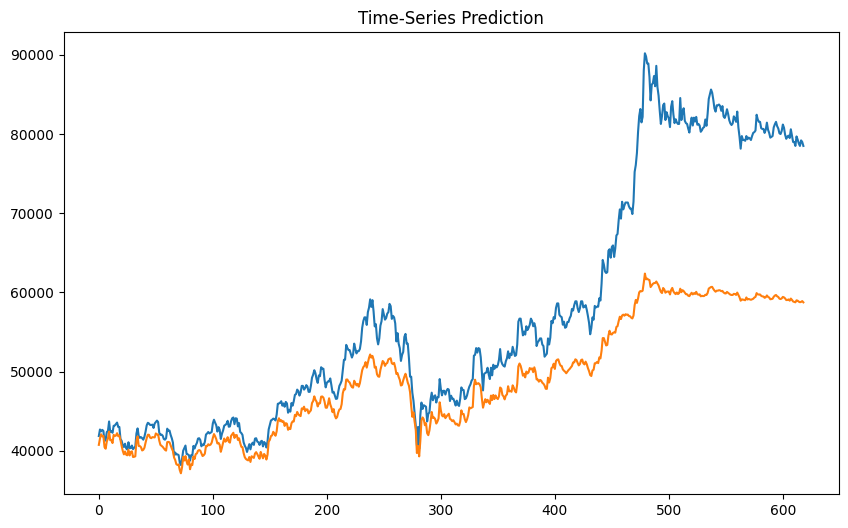

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Data')
plt.plot(prediction, label='Predicted Data')
plt.title('Time-Series Prediction')

In [ ]:
df_X_ss = ss.transform(df.drop(columns='Adj Close'))
df_y_mm = mm.transform(df.iloc[:, 4:5])
df_X_ss = torch.FloatTensor(df_X_ss)
df_y_mm = torch.FloatTensor(df_y_mm)

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

In [ ]:
df_X_ss

tensor([[[0.0356, 0.0372, 0.0394, 0.4518, 0.0383]],

        [[0.0351, 0.0356, 0.0371, 0.4548, 0.0323]],

        [[0.0321, 0.0363, 0.0366, 0.3312, 0.0327]],

        ...,

        [[0.8128, 0.8691, 0.8633, 0.0776, 0.8663]],

        [[0.8150, 0.8771, 0.8690, 0.0874, 0.8641]],

        [[0.8097, 0.8737, 0.8701, 0.0842, 0.8584]]])

In [ ]:
train_pred = model(df_X_ss.to(device))

train_pred = train_pred.data.detach().cpu().numpy()
train_data = df_y_mm.data.numpy()

In [ ]:
train_pred = mm.inverse_transform(train_pred)
train_data = mm.inverse_transform(train_data)

In [ ]:
train_pred

array([[ 4530.056 ],
       [ 4378.5767],
       [ 4305.897 ],
       ...,
       [58810.09  ],
       [58911.58  ],
       [58751.996 ]], dtype=float32)

Text(0.5, 1.0, 'Time-Series Prediction')

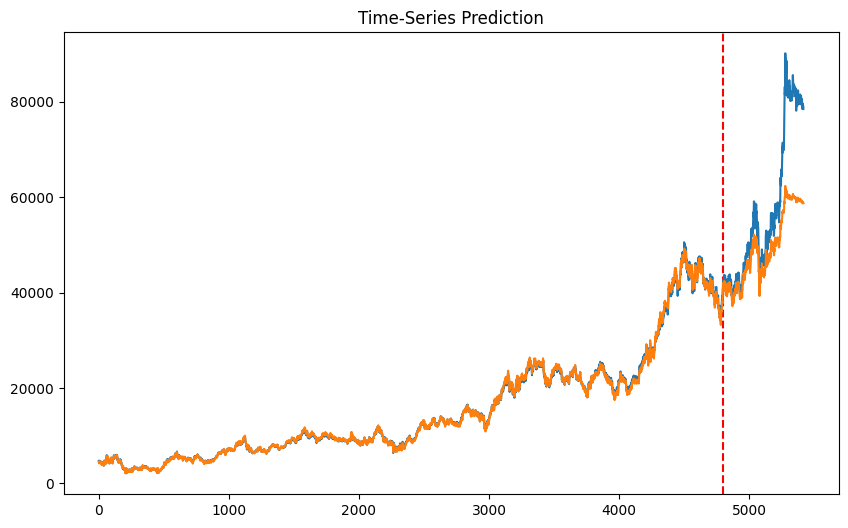

In [ ]:
plt.figure(figsize=(10, 6))
plt.axvline(x=4800, c='r', linestyle='--')
plt.plot(train_data, label='Actual Data')
plt.plot(train_pred, label='Predicted Data')
plt.title('Time-Series Prediction')